In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
#import torch.autograd.variable as Variable
from torchvision import transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform=transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))]) #converts images to pytorch tensors, normalizes pixel values of images
train_set=torchvision.datasets.MNIST(root='./MNIST_data/train',train=True,transform=transform,download=True) #creates training dataset object
train_loader=torch.utils.data.DataLoader(train_set,batch_size=64,shuffle=True,num_workers=4) #creates training data loader to load data in batches

test_set=torchvision.datasets.MNIST(root='./MNIST_data/test',train=False,transform=transform,download=True) #creates test dataset object
test_loader=torch.utils.data.DataLoader(test_set,batch_size=64,shuffle=True,num_workers=4) #data loader for testing dataset

In [3]:
device

device(type='cpu')

In [4]:
images,label=next(iter(test_loader))
images.size()

torch.Size([64, 1, 28, 28])

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,10,kernel_size=5)
        self.conv2=nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop=nn.Dropout() #dropout layer
        self.fc1=nn.Linear(320,50)
        self.fc2=nn.Linear(50,10)
         
    def forward(self,x):
        x=F.relu(F.max_pool2d(self.conv1(x),2))
        x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x=x.view(-1,320) #flattened to 1-dimensional tensor
        x=self.fc1(x)
        x=F.relu(x)
        x=F.dropout(x,training=self.training)
        x=self.fc2(x)
        return F.log_softmax(x,dim=1) #output tensor containing probabilities for each class
    
net=Net().to(device)
        

In [6]:
images,target=next(iter(train_loader))

In [12]:
optimizer=optim.SGD(net.parameters(),lr=0.01)
t_loss = []
acc = []
def train(epoch):
    net.train()
    for batch_idx,(data,target) in enumerate(train_loader):
        data,target=data.to(device),target.to(device)
        optimizer.zero_grad()
        output=net(data)
        loss=F.nll_loss(output,target)
        loss.backward() #computes gradients of loss
        optimizer.step() #updates model parameters
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    with torch.no_grad():
        net.eval()
        test_loss=0
        correct=0
        for data,target in test_loader:
            data,target=data.to(device),target.to(device)
            output=net(data)
            test_loss+=F.nll_loss(output,target,size_average=False).item()
            pred=output.max(1,keepdim=True)[1] #obtain predicted class label
            correct+=pred.eq(target.view_as(pred)).sum().item()
        test_loss/=len(test_loader.dataset)
        t_loss.append(test_loss)
        acc.append(correct/len(test_loader.dataset))
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))    

In [13]:
for epoch in range(1, 20):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.157180
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.311241


/Users/ryanliu/Library/Python/3.9/lib/python/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0412, Accuracy: 9898/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.010554
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.112904

Test set: Average loss: 0.0443, Accuracy: 9896/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.052243
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.045695

Test set: Average loss: 0.0431, Accuracy: 9896/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.158036
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.050581

Test set: Average loss: 0.0415, Accuracy: 9907/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.049539
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.142173

Test set: Average loss: 0.0433, Accuracy: 9899/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.061939
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.242419

Test set: Average loss: 0.0415, Accuracy: 9902/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.113824
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.042365

Test set: Average loss: 0.0378, Accuracy: 9905/10000 (99%)

Tra

In [14]:
len(t_loss)

19

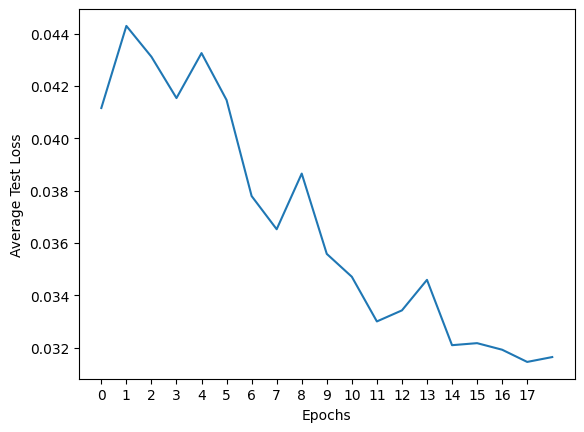

In [15]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(19), t_loss)
plt.xticks(np.arange(0, 18, 1))
plt.xlabel('Epochs')
plt.ylabel('Average Test Loss')
plt.show()

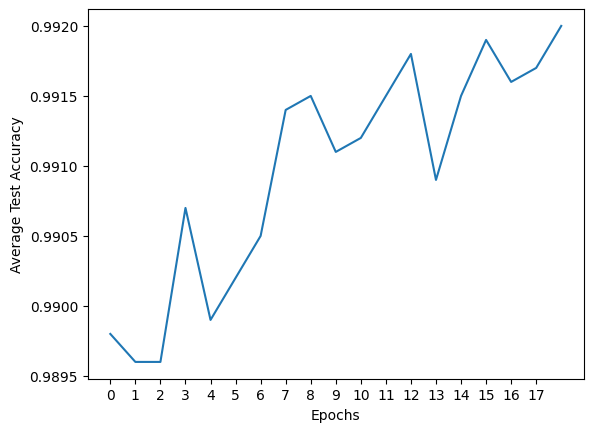

In [16]:
plt.plot(np.arange(19), acc)
plt.xticks(np.arange(0, 18, 1))
plt.xlabel('Epochs')
plt.ylabel('Average Test Accuracy')
plt.show()